# Set Config and Complie

In [1]:
import numpy as np
import tensorflow as tf
import hls4ml
import h5py
import matplotlib.pyplot as plt

from huggingface_hub import from_pretrained_keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from qkeras import *
from qkeras.utils import load_qmodel

from sklearn.metrics import roc_curve, auc

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
org_model = from_pretrained_keras("cicada-project/cicada-v1.1");

config.json not found in HuggingFace Hub.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
input_ = Input(shape = (252,), name="inputs_")
x = org_model.layers[1](input_)
x = org_model.layers[2](x)
x = org_model.layers[3](x)
x = org_model.layers[4](x)
output = Activation('relu', name='relu2')(x)

student = Model(input_, output, name='cicada')
student.summary()

Model: "cicada"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_ (InputLayer)         [(None, 252)]             0         
_________________________________________________________________
dense1 (QDense)              (None, 15)                3780      
_________________________________________________________________
QBN1 (QBatchNormalization)   (None, 15)                60        
_________________________________________________________________
relu1 (QActivation)          (None, 15)                0         
_________________________________________________________________
output (QDense)              (None, 1)                 15        
_________________________________________________________________
relu2 (Activation)           (None, 1)                 0         
Total params: 3,855
Trainable params: 3,825
Non-trainable params: 30
_________________________________________________________

In [6]:
hls4ml.model.optimizer.get_optimizer(
    'output_rounding_saturation_mode'
).configure(
    layers=['relu1', 'QBN1', 'relu2'],
    rounding_mode='AP_RND',
    saturation_mode='AP_SAT',
    saturation_bits='AP_SAT'
)

# Create hls4ml config
hls_config = hls4ml.utils.config_from_keras_model(student, granularity='name', backend='Vitis')

# Set the model config
hls_config['Model']['ReuseFactor'] = 3
hls_config['Model']['Strategy'] = 'Latency'
hls_config['Model']['ClockPeriod']  = 6.25
hls_config['Model']['Trace']  = False

hls_config['LayerName']['inputs_']['Precision']['accum'] = 'ap_ufixed<10, 10>'
hls_config['LayerName']['inputs_']['Precision']['result'] = 'ap_ufixed<10, 10>'

hls_config['LayerName']['dense1']['Precision']['accum'] = 'ap_fixed<20, 18>'
hls_config['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<20, 18>'
hls_config['LayerName']['dense1']['ReuseFactor'] = 4
hls_config['LayerName']['dense1_linear']['Precision'] = 'ap_fixed<20, 18>'

hls_config['LayerName']['QBN1']['Precision']['scale'] = 'ap_fixed<18, 3>'
hls_config['LayerName']['QBN1']['Precision']['bias'] = 'ap_fixed<18, 3>'
hls_config['LayerName']['QBN1']['Precision']['accum'] = 'ap_fixed<15, 12>'
hls_config['LayerName']['QBN1']['Precision']['result'] = 'ap_fixed<15, 12>'

hls_config['LayerName']['relu1']['Precision']['result'] = 'ap_ufixed<5, 2>'

hls_config['LayerName']['output']['Precision']['accum'] = 'ap_fixed<16, 8>'
hls_config['LayerName']['output']['Precision']['result'] = 'ap_fixed<16, 8>'
hls_config['LayerName']['output_linear']['Precision'] = 'ap_fixed<16, 8>'

hls_config['LayerName']['relu2']['Precision']['result'] = 'ap_ufixed<16, 8>'

# Finish setting up the config
cfg = hls4ml.converters.create_config()
cfg['IOType'] = 'io_parallel'
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = student
cfg['ClockPeriod']  = 6.25
cfg['OutputDir']  = 'cicada-v1.aug-foo/'
cfg['Part'] = 'xc7vx690tffg1927-2'
cfg['Version'] = '1.1.0'

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 252]], output shape: [None, 252]
Layer name: dense1, layer type: QDense, input shapes: [[None, 252]], output shape: [None, 15]
Layer name: QBN1, layer type: QBatchNormalization, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: relu1, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: output, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 1]
Layer name: relu2, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]


In [7]:
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls4ml.model.optimizer.get_optimizer(
    'output_rounding_saturation_mode'
).configure(layers=[])
hls_model.compile()

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 252]], output shape: [None, 252]
Layer name: dense1, layer type: QDense, input shapes: [[None, 252]], output shape: [None, 15]
Layer name: QBN1, layer type: QBatchNormalization, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: relu1, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: output, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 1]
Layer name: relu2, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model
Writing HLS project
Done


# Testing

In [8]:
ACCEPTED_ERROR = 0.25

In [9]:
# Test vector, zeros:
tv_0 = np.zeros((1, 252)) + 0.

# Test vector, ones:
tv_1 = np.zeros((1, 252)) + 1.

# Test vector, mean zero bias, 2018 run D:
tv_zb = np.array([[2, 1, 1, 2, 1, 2, 3, 3, 3, 2, 3, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 2, 3, 1, 1, 2],
       [2, 1, 1, 1, 2, 2, 3, 3, 2, 2, 3, 1, 1, 2],
       [2, 1, 1, 2, 1, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 4, 3, 2, 4, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1, 2],
       [2, 1, 1, 3, 2, 3, 5, 2, 2, 1, 3, 1, 1, 2],
       [2, 1, 1, 2, 2, 3, 4, 3, 2, 2, 2, 1, 1, 3],
       [2, 1, 1, 2, 2, 3, 4, 3, 2, 1, 2, 1, 1, 3],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 3, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [0, 0, 0, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1, 2],
       [0, 0, 0, 3, 2, 3, 5, 4, 3, 2, 4, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 4, 3, 2, 2, 4, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 3, 1, 1, 2]]).reshape(1, 252) + 0.

# Test vector, signal haa4b_ma15_powheg average:
tv_sig = np.array([[8, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 8],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 9],
       [9, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 9],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 9],
       [8, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 8],
       [8, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 8],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 9],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 9],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 8],
       [8, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 8],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 8],
       [9, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 9],
       [9, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 9],
       [8, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 8],
       [8, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 8],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 9],
       [9, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 9],
       [8, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 2, 8]]).reshape(1, 252) + 0.

# Test vector, hand made:
tv_hand = np.array([[2, 1, 1, 2, 1, 2, 3, 3, 3, 2, 3, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 2, 3, 1, 1, 2],
       [2, 1, 1, 1, 2, 2, 1023, 3, 2, 2, 3, 1, 1, 2],
       [2, 1, 1, 2, 1, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 1023, 1023, 2, 3, 4, 3, 2, 4, 1023, 1, 2],
       [2, 1, 1023, 1023, 2, 2, 3, 3, 2, 2, 2, 1, 1, 2],
       [2, 1, 1, 3, 2, 3, 5, 2, 2, 1, 3, 1023, 1, 2],
       [2, 1, 1, 2, 2, 3, 4, 3, 2, 2, 2, 1, 1, 3],
       [2, 1, 1, 2, 2, 3, 4, 3, 2, 1, 2, 1, 1, 3],
       [2, 1, 1, 2, 2, 2, 3, 3, 1023, 1, 2, 1, 1, 2],
       [2, 1, 1, 1023, 2, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 3, 3, 2, 1, 3, 1, 1, 2],
       [2, 1, 1, 2, 1023, 2, 3, 3, 2, 1, 2, 1, 1, 2],
       [0, 1023, 0, 2, 2, 2, 3, 3, 2, 2, 2, 1, 1, 2],
       [0, 0, 0, 3, 2, 3, 5, 4, 3, 2, 4, 1, 1, 2],
       [2, 1, 1, 2, 2, 2, 4, 3, 2, 2, 1023, 1, 1, 2],
       [2, 1023, 1, 2, 2, 2, 3, 3, 2, 1, 3, 1, 1, 2]]).reshape(1, 252) + 0.

In [10]:
for tv in [tv_0, tv_1, tv_zb, tv_sig, tv_hand]:
    print(abs(org_model.predict(tv) - hls_model.predict(tv)) <= ACCEPTED_ERROR)

2023-08-21 14:38:27.351414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[[ True]]
[[ True]]
[[ True]]
[[ True]]
[[ True]]


In [11]:
# Real signal samples

scores = {
    'scores_hls4ml': {},
    'scores_keras': {}
}

for dataset_path in [
    '/eos/project/c/cicada-project/data/2023/Signal/SUEP.h5',
    '/eos/project/c/cicada-project/data/2023/Signal/H_ToLongLived.h5',
    '/eos/project/c/cicada-project/data/2023/Signal/SUSYGGBBH.h5',
    '/eos/project/c/cicada-project/data/2023/Signal/TT.h5',
    '/eos/project/c/cicada-project/data/2023/Signal/VBFHto2C.h5',
    '/eos/project/c/cicada-project/data/2023/Background/ZB_RunA_2.h5']:
    X_test = h5py.File(dataset_path, 'r')['CaloRegions'][:]
    test_vectors = X_test.reshape(-1, 252)
    scores_hls4ml = hls_model.predict(test_vectors)
    scores_keras = org_model.predict(test_vectors)
    signal_name = dataset_path.split('/')[-1][:-3]
    scores['scores_hls4ml'][signal_name] = scores_hls4ml.flatten()
    scores['scores_keras'][signal_name] = scores_keras.flatten()

In [12]:
scores_hls4ml = np.concatenate(list(scores['scores_hls4ml'].values()))
scores_keras = np.concatenate(list(scores['scores_keras'].values()))

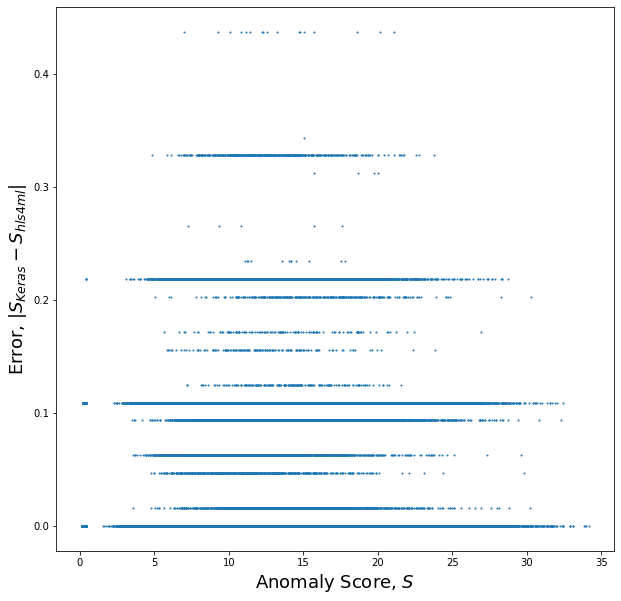

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(scores_keras, np.abs(scores_keras-scores_hls4ml), s=1)
plt.xlabel('Anomaly Score, $S$', fontsize=18)
plt.ylabel('Error, $|S_{Keras} - S_{hls4ml}|$', fontsize=18);

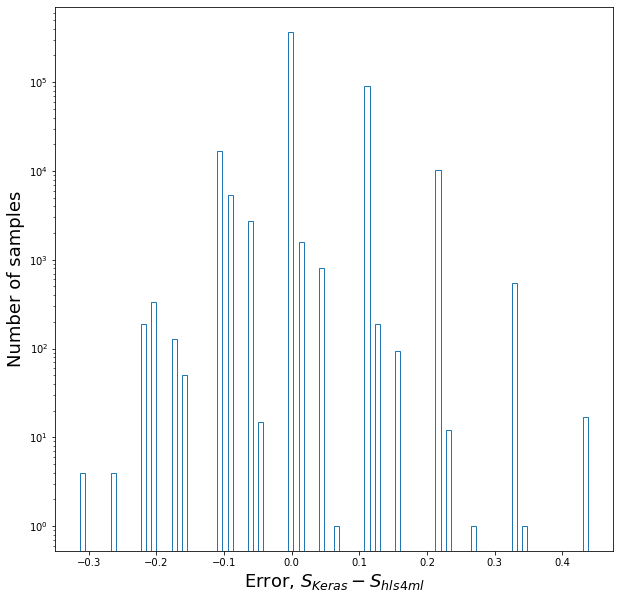

In [14]:
plt.figure(figsize=(10, 10))
plt.hist(scores_keras - scores_hls4ml, fc='none', histtype='step', label='Error distribution', bins=100)
plt.yscale('log')
plt.xlabel('Error, $S_{Keras} - S_{hls4ml}$', fontsize=18)
plt.ylabel('Number of samples', fontsize=18);

# QKeras and HLS4ML Comparison

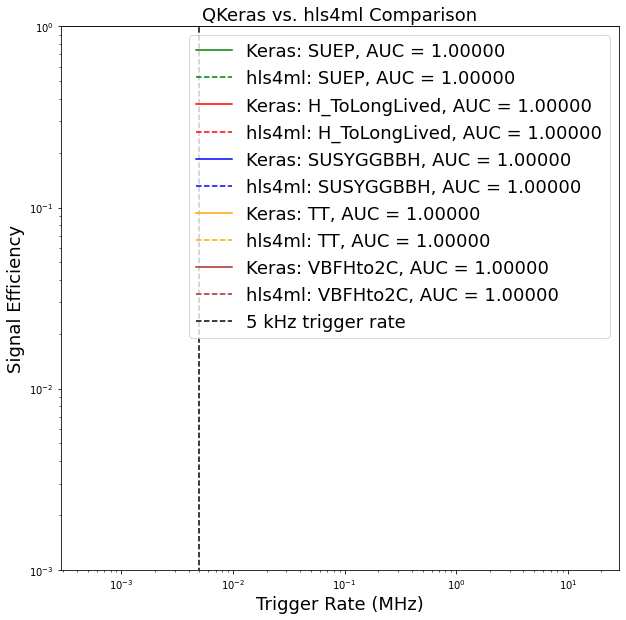

In [15]:
plt.figure(figsize = (10, 10))

axes = plt.subplot(1, 1, 1)

fpr_model = []
tpr_model = []
cmap = ['green', 'red', 'blue', 'orange', 'brown']

scores_keras_normal = scores['scores_keras']['ZB_RunA_2']
scores_hls4ml_normal = scores['scores_hls4ml']['ZB_RunA_2']

for dataset_name, color in zip(list(scores['scores_keras'].keys())[:-1], cmap):
    scores_keras_anomaly = scores['scores_keras'][dataset_name]
    scores_hls4ml_anomaly = scores['scores_hls4ml'][dataset_name]
    
    y_true = np.append(np.zeros(len(scores_keras_normal)), np.ones(len(scores_hls4ml_anomaly)))
    y_score_keras = np.append(scores_keras_normal, scores_keras_anomaly)
    y_score_hls = np.append(scores_hls4ml_normal, scores_hls4ml_anomaly)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score_keras)
    roc_auc = auc(fpr, tpr)
    
    axes.plot(fpr*28.61,
              tpr,
              linestyle = '-',
              lw = 1.5,
              color=color,
              label = 'Keras: {0}, AUC = {1:.5f}'.format(dataset_name, roc_auc))
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score_hls)
    roc_auc = auc(fpr, tpr)
    fpr *= 28.61
    
    axes.plot(fpr*28.61,
              tpr,
              linestyle = '--',
              lw = 1.5,
              color=color,
              label = 'hls4ml: {0}, AUC = {1:.5f}'.format(dataset_name, roc_auc))

axes.plot([0.005, 0.005], [0, 1], linestyle = '--', lw = 1.5, color = 'black', label = '5 kHz trigger rate')
axes.set_xlim([0.0002861, 28.61])
axes.set_ylim([0.001, 1.0])
axes.set_xscale(value = "log")
axes.set_yscale(value = "log")
axes.set_xlabel('Trigger Rate (MHz)', fontsize=18)
axes.set_ylabel('Signal Efficiency', fontsize=18)
axes.set_title('QKeras vs. hls4ml Comparison', fontsize=18)
axes.legend(fontsize=18)
plt.show()